#### Load and process data

In [1]:
using QuantumACES, StatsBase, LinearAlgebra, DataFrames, GLM, Optim
using Plots, Plots.PlotMeasures, StatsPlots, ColorSchemes, LaTeXStrings, JLD2, PrettyTables
# Set default plot parameters
pgfplotsx()
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7)
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amsmath}")
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amssymb}")
# :tol_bright is a colourblind-friendly colourscheme
tol_bright = ColorSchemes.tol_bright
colour_series = [tol_bright[3]; tol_bright[1]; tol_bright[2]; tol_bright[4]; tol_bright[5]]
# In REVTeX, one column width is 246 pt, and the text width is 510 pt
col_width = 246.0
text_width = 510.0
aspect_ratio = 4 / 3
inches_per_pt = 1.0 / 72.27
default_dpi = 100.0
col_width_px = col_width * inches_per_pt * default_dpi
text_width_px = text_width * inches_per_pt * default_dpi
col_height_px = col_width_px / aspect_ratio
text_height_px = text_width_px / aspect_ratio
triple_height = (1 + 2 * (text_width / col_width - 1)) * col_width / aspect_ratio
triple_height_px = triple_height * inches_per_pt * default_dpi;

In [2]:
# Initialise data loading parameters
dist = 3
big_dist = 17
r_1 = 0.075 / 100
r_2 = 0.5 / 100
r_m = 2.0 / 100
total_std_log = sqrt(log(10 / 9))
seed = UInt(0)
ls_type = :wls
budget_set = [10^6; 10^7; 10^8; 10^9]
S = length(budget_set)
unrotated_param = get_unrotated_param(dist)
unrotated_param_big = get_unrotated_param(big_dist)
dep_param = get_dep_param(r_1, r_2, r_m)
log_param = get_log_param(r_1, r_2, r_m, total_std_log; seed=seed)
# Load the metadata
metadata_dict = load("data/design_metadata_$(unrotated_param.circuit_name).jld2")
@assert unrotated_param == metadata_dict["unrotated_param"]
@assert dep_param == metadata_dict["dep_param"]
dep_param_set = metadata_dict["dep_param_set"]
tuple_number_set = metadata_dict["tuple_number_set"]
repeat_numbers_set = metadata_dict["repeat_numbers_set"]
dep_idx = 14
@assert dep_param == dep_param_set[dep_idx]
tuple_number = tuple_number_set[dep_idx]
repeat_numbers = repeat_numbers_set[dep_idx]
# Load the data
aces_data_dep = load_aces(unrotated_param_big, dep_param, tuple_number, repeat_numbers, false, :none, budget_set)
aces_data_log = load_aces(unrotated_param_big, log_param, tuple_number, repeat_numbers, false, :none, budget_set)
dep_planar_scaling = load_scaling(unrotated_param, dep_param, tuple_number, repeat_numbers, ls_type)
log_planar_scaling = load_scaling(unrotated_param, log_param, tuple_number, repeat_numbers, ls_type)
# Display how long the data took to generate
@assert aces_data_dep.d.overall_time ≈ aces_data_log.d.overall_time
println("The design took $(round(aces_data_dep.d.overall_time/3600, digits = 2)) hours to generate.")
println("The depolarising noise simulation took $(round(aces_data_dep.overall_time/3600, digits = 2)) hours.")
println("The log-normal Pauli noise simulation took $(round(aces_data_log.overall_time/3600, digits = 2)) hours.")
println("The design has $(length(aces_data_dep.d.tuple_set)) tuples, $(aces_data_dep.d.experiment_number) experiments, $(size(aces_data_dep.d.matrix, 1)) circuit eigenvalues, and $(size(aces_data_dep.d.matrix, 2)) gate eigenvalues.")

The design took 0.55 hours to generate.
The depolarising noise simulation took 2.29 hours.
The log-normal Pauli noise simulation took 2.16 hours.
The design has 25 tuples, 870 experiments, 195723 circuit eigenvalues, and 38610 gate eigenvalues.


In [3]:
# Fit the scaling data
G_fit = dep_planar_scaling.G_fit
G_params = dep_planar_scaling.G_params
N_fit = dep_planar_scaling.N_fit
N_params = dep_planar_scaling.N_params
trace_fit = dep_planar_scaling.trace_fit
trace_params = dep_planar_scaling.trace_params
trace_sq_fit = dep_planar_scaling.trace_sq_fit
trace_sq_params = dep_planar_scaling.trace_sq_params
expectation_fit = dep_planar_scaling.expectation_fit
variance_fit = dep_planar_scaling.variance_fit
expectation_fit_log = log_planar_scaling.expectation_fit
variance_fit_log = log_planar_scaling.variance_fit
# Predict the NRMSE with the fits
pred_expectation_dep = expectation_fit(big_dist)
pred_std_dep = sqrt(variance_fit(big_dist))
pred_expectation_log = expectation_fit_log(big_dist)
pred_std_log = sqrt(variance_fit_log(big_dist))
# Examine the depolarising noise data
header = ["Shots", "NRMSE", "Pred. z-score"]
gate_norm_dep = vec(aces_data_dep.wls_gate_norm_coll)
z_score_dep = (gate_norm_dep .- pred_expectation_dep) / pred_std_dep
gate_norm_log = vec(aces_data_log.wls_gate_norm_coll)
z_score_log = (gate_norm_log .- pred_expectation_log) / pred_std_log
println("For depolarising noise, the predicted expected NRMSE is $(round(pred_expectation_dep; digits=4)), with predicted standard deviation $(round(pred_std_dep; digits=4)).")
pretty_table(hcat(budget_set, gate_norm_dep, z_score_dep);
    header=header,
    alignment=:l,
    formatters=(ft_printf("%.1e", 1), ft_printf("%.4f")))
println("For log-normal Pauli noise, the predicted mean expected NRMSE is $(round(pred_expectation_log; digits=4)), with predicted mean standard deviation $(round(pred_std_log; digits=4)).")
pretty_table(hcat(budget_set, gate_norm_log, z_score_log);
    header=header,
    alignment=:l,
    formatters=(ft_printf("%.1e", 1), ft_printf("%.4f")))
println("Both simulations are consistent with fit extrapolations for the figure of merit and NRMSE standard deviation.")

For depolarising noise, the predicted expected NRMSE is 1.3306, with predicted standard deviation 0.01.
┌─────────┬────────┬───────────────┐
│ Shots   │ NRMSE  │ Pred. z-score │
├─────────┼────────┼───────────────┤
│ 1.0e+06 │ 1.3475 │ 1.6919        │
│ 1.0e+07 │ 1.3329 │ 0.2310        │
│ 1.0e+08 │ 1.3210 │ -0.9668       │
│ 1.0e+09 │ 1.3238 │ -0.6876       │
└─────────┴────────┴───────────────┘
For log-normal Pauli noise, the predicted mean expected NRMSE is 1.3249, with predicted mean standard deviation 0.01.
┌─────────┬────────┬───────────────┐
│ Shots   │ NRMSE  │ Pred. z-score │
├─────────┼────────┼───────────────┤
│ 1.0e+06 │ 1.3135 │ -1.1414       │
│ 1.0e+07 │ 1.3207 │ -0.4189       │
│ 1.0e+08 │ 1.3237 │ -0.1118       │
│ 1.0e+09 │ 1.3181 │ -0.6807       │
└─────────┴────────┴───────────────┘
Both simulations are consistent with fit extrapolations for the figure of merit and NRMSE standard deviation.


In [4]:
# Calculate the eigenvalue estimator deviations
eigenvalues_dep = aces_data_dep.eigenvalues
gate_eigenvalues_dep = aces_data_dep.d.c.gate_eigenvalues
est_eigenvalues_coll_dep = aces_data_dep.est_eigenvalues_coll
est_gate_eigenvalues_coll_dep = aces_data_dep.wls_gate_eigenvalues_coll
eigenvalues_deviation_dep = [est_eigenvalues_coll_dep[1, shot_idx] - eigenvalues_dep for shot_idx in 1:S]
eigenvalues_log = aces_data_log.eigenvalues
gate_eigenvalues_log = aces_data_log.d.c.gate_eigenvalues
est_eigenvalues_coll_log = aces_data_log.est_eigenvalues_coll
est_gate_eigenvalues_coll_log = aces_data_log.wls_gate_eigenvalues_coll
eigenvalues_deviation_log = [est_eigenvalues_coll_log[1, shot_idx] - eigenvalues_log for shot_idx in 1:S]
# Calculate the gate TVDs
gate_probabilities_dep = aces_data_dep.d.c.gate_probabilities
est_gate_probabilities_coll_dep = aces_data_dep.wls_gate_probabilities_coll
gates = aces_data_dep.d.c.total_gates
gate_tvd_coll_dep = [Dict{Gate,Float64}([(gate, norm(est_gate_probabilities_coll_dep[1, shot_idx][gate] - gate_probabilities_dep[gate], 1) / 2) for gate in gates]) for shot_idx in 1:S]
gate_probabilities_log = aces_data_log.d.c.gate_probabilities
est_gate_probabilities_coll_log = aces_data_log.wls_gate_probabilities_coll
@assert gates == aces_data_log.d.c.total_gates
gate_tvd_coll_log = [Dict{Gate,Float64}([(gate, norm(est_gate_probabilities_coll_log[1, shot_idx][gate] - gate_probabilities_log[gate], 1) / 2) for gate in gates]) for shot_idx in 1:S]
# Divide up the gate TVDs
gate_tvd_list_dep = collect.(values.(gate_tvd_coll_dep))
meas_tvd_list_dep = [[gate_tvd_coll_dep[shot_idx][gate] for gate in gates if gate.type[1] == 'M'] for shot_idx in 1:S]
pauli_tvd_list_dep = [[gate_tvd_coll_dep[shot_idx][gate] for gate in gates if gate.type[1] == 'X' || gate.type[1] == 'I'] for shot_idx in 1:S]
h_tvd_list_dep = [[gate_tvd_coll_dep[shot_idx][gate] for gate in gates if gate.type[1] == 'H'] for shot_idx in 1:S]
cx_tvd_list_dep = [[gate_tvd_coll_dep[shot_idx][gate] for gate in gates if length(gate.type) >= 2 && gate.type[1:2] == "CX"] for shot_idx in 1:S]
@assert length.(gate_tvd_list_dep) == length.(meas_tvd_list_dep) + length.(pauli_tvd_list_dep) + length.(h_tvd_list_dep) + length.(cx_tvd_list_dep)
gate_tvd_list_log = collect.(values.(gate_tvd_coll_log))
meas_tvd_list_log = [[gate_tvd_coll_log[shot_idx][gate] for gate in gates if gate.type[1] == 'M'] for shot_idx in 1:S]
pauli_tvd_list_log = [[gate_tvd_coll_log[shot_idx][gate] for gate in gates if gate.type[1] == 'X' || gate.type[1] == 'I'] for shot_idx in 1:S]
h_tvd_list_log = [[gate_tvd_coll_log[shot_idx][gate] for gate in gates if gate.type[1] == 'H'] for shot_idx in 1:S]
cx_tvd_list_log = [[gate_tvd_coll_log[shot_idx][gate] for gate in gates if length(gate.type) >= 2 && gate.type[1:2] == "CX"] for shot_idx in 1:S]
@assert length.(gate_tvd_list_log) == length.(meas_tvd_list_log) + length.(pauli_tvd_list_log) + length.(h_tvd_list_log) + length.(cx_tvd_list_log)
# Calculate the -log10(TVD)
log_gate_tvd_list_dep = [-log10.(gate_tvd_list_dep[shot_idx]) for shot_idx in 1:S]
log_meas_tvd_list_dep = [-log10.(meas_tvd_list_dep[shot_idx]) for shot_idx in 1:S]
log_h_tvd_list_dep = [-log10.(h_tvd_list_dep[shot_idx]) for shot_idx in 1:S]
log_pauli_tvd_list_dep = [-log10.(pauli_tvd_list_dep[shot_idx]) for shot_idx in 1:S]
log_cx_tvd_list_dep = [-log10.(cx_tvd_list_dep[shot_idx]) for shot_idx in 1:S]
log_gate_tvd_list_log = [-log10.(gate_tvd_list_log[shot_idx]) for shot_idx in 1:S]
log_meas_tvd_list_log = [-log10.(meas_tvd_list_log[shot_idx]) for shot_idx in 1:S]
log_h_tvd_list_log = [-log10.(h_tvd_list_log[shot_idx]) for shot_idx in 1:S]
log_pauli_tvd_list_log = [-log10.(pauli_tvd_list_log[shot_idx]) for shot_idx in 1:S]
log_cx_tvd_list_log = [-log10.(cx_tvd_list_log[shot_idx]) for shot_idx in 1:S];

### Histograms of the TVDs between the estimated and true gate Pauli error probability distributions, as well as the circuit eigenvalue estimator residuals, for both depolarising and log-normal Pauli noise

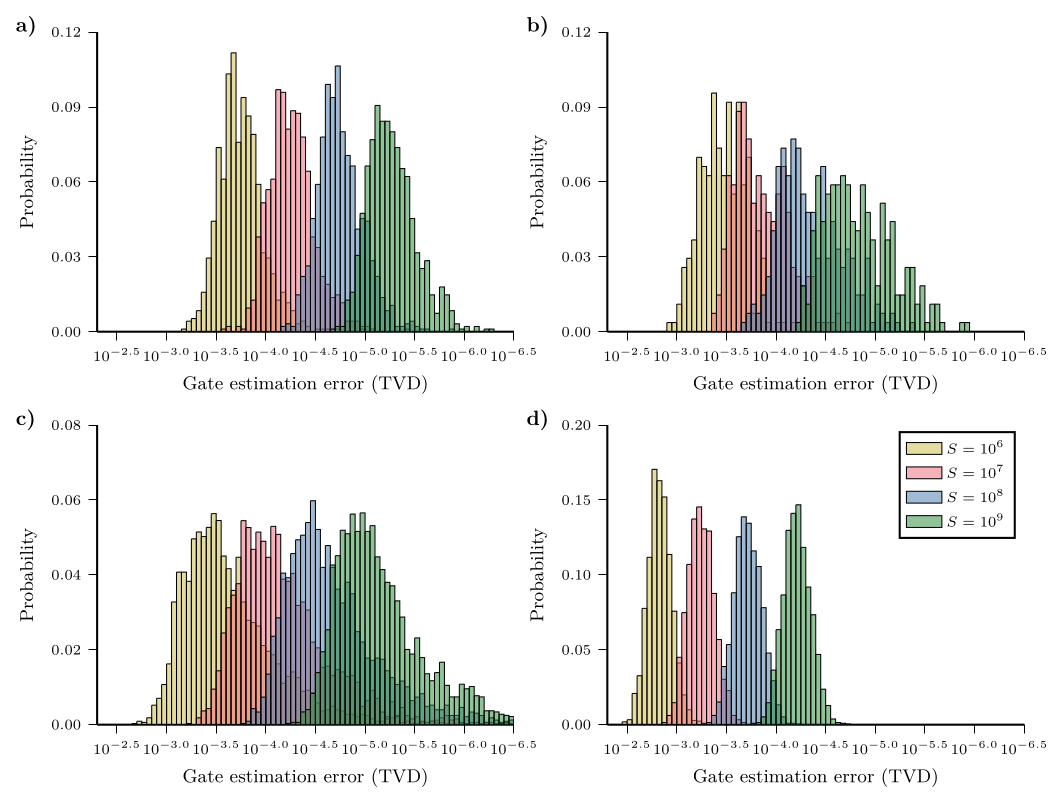

In [5]:
# Histograms of the gate reconstruction TVDs for a simulated trial of ACES on an instance of lognormal noise
noise_name = "lognormal"
margin_val = 7.5px
x_lim_min = 2.3
x_lim_max = 6.5
x_min = 2.0
x_max = 7.0
x_int = 0.5
bin_int = 0.05
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    palette=reverse(colour_series[1:4]),
    normalize=:probability,
    xlims=(x_lim_min, x_lim_max), xticks=(x_min:x_int:x_max, [L"10^{-%$(x)}" for x in x_min:x_int:x_max]),
    xguide="Gate estimation error (TVD)",
    bins=x_min:bin_int:x_max, yguide="Probability",
    legend=false)
# Pauli (X, I) gate TVD
y_max = 0.12
y_int = 0.03
pauli_hist_log = histogram(hcat(log_pauli_tvd_list_log...);
    ylims=(0, y_max), yticks=0:y_int:y_max,
    linewidth=0.5,
    extra_kwargs=:plot,
    add=raw"
    \node[anchor=south west] at (0.0-1.5,0.0-0.2) {\textbf{a)}};
    \node[anchor=south west] at (8.645-1.5,0.0-0.2) {\textbf{b)}};
    \node[anchor=south west] at (0.0-1.5,-6.665-0.2) {\textbf{c)}};
    \node[anchor=south west] at (8.645-1.5,-6.665-0.2) {\textbf{d)}};
    ")
# \node at (0.0,0.0) {\textbf{o}};
# \node at (8.645,0.0) {\textbf{o}};
# \node at (0.0,-6.665) {\textbf{o}};
# \node at (8.645,-6.665) {\textbf{o}};
# Hadamard gate TVD
y_max = 0.12
y_int = 0.03
h_hist_log = histogram(hcat(log_h_tvd_list_log...);
    ylims=(0, y_max), yticks=0:y_int:y_max,
    linewidth=0.5,
)
# Measurement TVD
y_max = 0.08
y_int = 0.02
meas_hist_log = histogram(hcat(log_meas_tvd_list_log...);
    ylims=(0, y_max), yticks=0:y_int:y_max,
    linewidth=0.5,
)
# CX gate TVD
y_max = 0.20
y_int = 0.05
cx_hist_log = histogram(hcat(log_cx_tvd_list_log...);
    ylims=(0, y_max), yticks=0:y_int:y_max,
    linewidth=0.5,
    label=hcat([L"S=10^{%$(convert(Int64,round(log10(shots),digits=0)))}" for shots in budget_set]...),
    legend=:topright, legend_font_halign=:left,
)
tvd_hist_log = plot(pauli_hist_log, h_hist_log, meas_hist_log, cx_hist_log, layout=(2, 2), size=(text_width_px * 0.964, text_height_px * 0.99))
savefig(pwd() * "/figures/tvd_hist_$(unrotated_param_big.circuit_name)_$(noise_name).pdf")
display(tvd_hist_log)

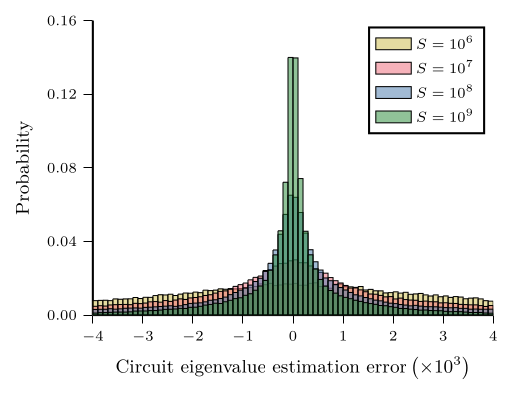

In [6]:
# Circuit eigenvalue estimator deviation
noise_name = "lognormal"
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    palette=reverse(colour_series[1:4]),
    normalize=:probability)
y_max = 0.16
y_int = 0.04
x_min = -4
x_max = 4
x_int = 1
bin_int = 0.1
eigenvalue_hist_log = histogram(10^3 * hcat(eigenvalues_deviation_log...);
    xlims=(x_min, x_max), xticks=x_min:x_int:x_max,
    xguide=L"\textrm{Circuit eigenvalue estimation error}\left(\times 10^3\right)",
    bins=x_min:bin_int:x_max,
    ylims=(0, y_max), yticks=0:y_int:y_max, yguide="Probability",
    label=hcat([L"S=10^{%$(convert(Int64,round(log10(shots),digits=0)))}" for shots in budget_set]...),
    legend=:topright, legend_font_halign=:left,
    linewidth=0.5,
    size=(col_width_px * 0.967, col_height_px * 1.013)
)
savefig(eigenvalue_hist_log, pwd() * "/figures/eigenvalue_hist_$(unrotated_param_big.circuit_name)_$(noise_name).pdf")
display(eigenvalue_hist_log)

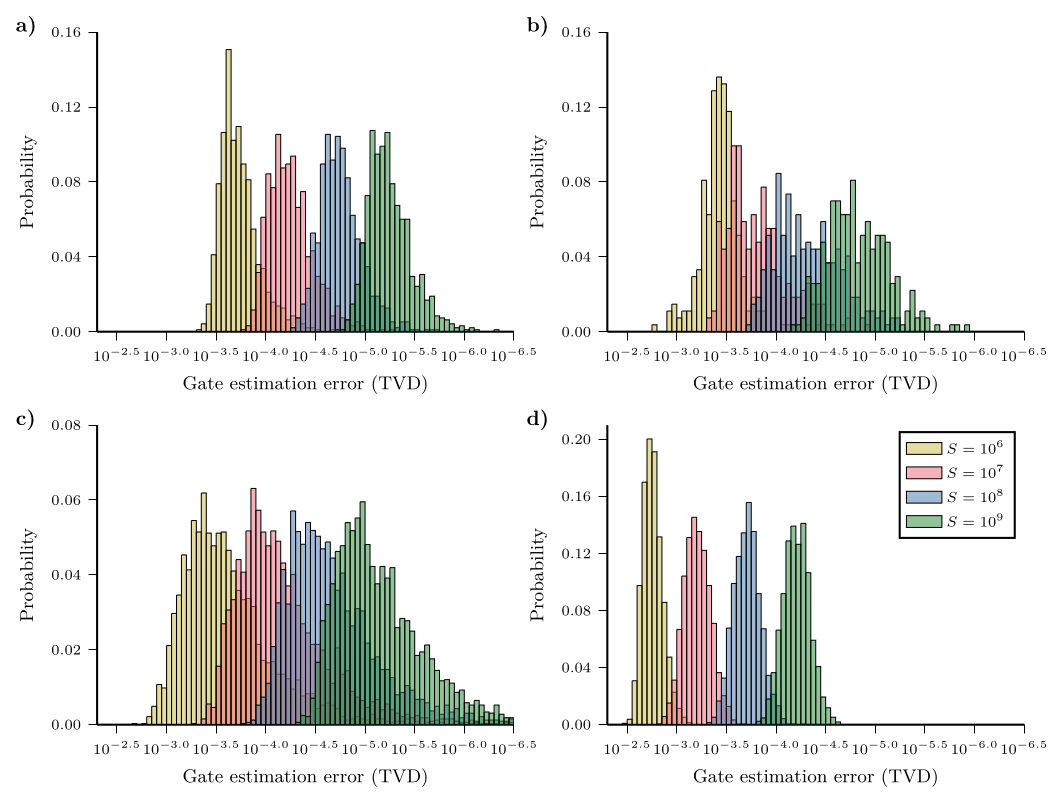

In [7]:
# Histograms of the gate reconstruction TVDs for a simulated trial of ACES on an instance of lognormal noise
noise_name = "depolarising"
margin_val = 7.5px
x_lim_min = 2.3
x_lim_max = 6.5
x_min = 2.0
x_max = 7.0
x_int = 0.5
bin_int = 0.05
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    palette=reverse(colour_series[1:4]),
    normalize=:probability,
    xlims=(x_lim_min, x_lim_max), xticks=(x_min:x_int:x_max, [L"10^{-%$(x)}" for x in x_min:x_int:x_max]),
    xguide="Gate estimation error (TVD)",
    bins=x_min:bin_int:x_max, yguide="Probability",
    legend=false)
# Pauli (X, I) gate TVD
y_max = 0.16
y_int = 0.04
pauli_hist_dep = histogram(hcat(log_pauli_tvd_list_dep...);
    ylims=(0, y_max), yticks=0:y_int:y_max,
    linewidth=0.5,
    extra_kwargs=:plot,
    add=raw"
    \node[anchor=south west] at (0.0-1.5,0.0-0.2) {\textbf{a)}};
    \node[anchor=south west] at (8.645-1.5,0.0-0.2) {\textbf{b)}};
    \node[anchor=south west] at (0.0-1.5,-6.665-0.2) {\textbf{c)}};
    \node[anchor=south west] at (8.645-1.5,-6.665-0.2) {\textbf{d)}};
    ")
# \node at (0.0,0.0) {\textbf{o}};
# \node at (8.645,0.0) {\textbf{o}};
# \node at (0.0,-6.665) {\textbf{o}};
# \node at (8.645,-6.665) {\textbf{o}};
# Hadamard gate TVD
y_max = 0.16
y_int = 0.04
h_hist_dep = histogram(hcat(log_h_tvd_list_dep...);
    ylims=(0, y_max), yticks=0:y_int:y_max,
    linewidth=0.5,
)
# Measurement TVD
y_max = 0.08
y_int = 0.02
meas_hist_dep = histogram(hcat(log_meas_tvd_list_dep...);
    ylims=(0, y_max), yticks=0:y_int:y_max,
    linewidth=0.5,
)
# CX gate TVD
y_max = 0.21
y_int = 0.04
cx_hist_dep = histogram(hcat(log_cx_tvd_list_dep...);
    ylims=(0, y_max), yticks=0:y_int:y_max,
    linewidth=0.5,
    label=hcat([L"S=10^{%$(convert(Int64,round(log10(shots),digits=0)))}" for shots in budget_set]...),
    legend=:topright, legend_font_halign=:left,
)
tvd_hist_dep = plot(pauli_hist_dep, h_hist_dep, meas_hist_dep, cx_hist_dep, layout=(2, 2), size=(text_width_px * 0.964, text_height_px * 0.99))
savefig(pwd() * "/figures/tvd_hist_$(unrotated_param_big.circuit_name)_$(noise_name).pdf")
display(tvd_hist_dep)

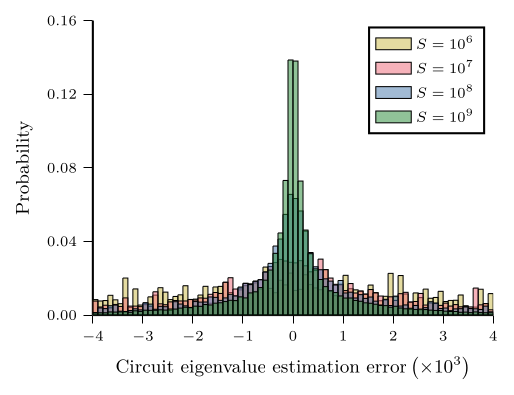

In [8]:
# Circuit eigenvalue estimator deviation
noise_name = "depolarising"
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    palette=reverse(colour_series[1:4]),
    normalize=:probability)
y_max = 0.16
y_int = 0.04
x_min = -4
x_max = 4
x_int = 1
bin_int = 0.1
eigenvalue_hist_dep = histogram(10^3 * hcat(eigenvalues_deviation_dep...);
    xlims=(x_min, x_max), xticks=x_min:x_int:x_max,
    xguide=L"\textrm{Circuit eigenvalue estimation error}\left(\times 10^3\right)",
    bins=x_min:bin_int:x_max,
    ylims=(0, y_max), yticks=0:y_int:y_max, yguide="Probability",
    label=hcat([L"S=10^{%$(convert(Int64,round(log10(shots),digits=0)))}" for shots in budget_set]...),
    legend=:topright, legend_font_halign=:left,
    linewidth=0.5,
    size=(col_width_px * 0.967, col_height_px * 1.013)
)
savefig(eigenvalue_hist_dep, pwd() * "/figures/eigenvalue_hist_$(unrotated_param_big.circuit_name)_$(noise_name).pdf")
display(eigenvalue_hist_dep)

#### Investigating ACES performance

In [9]:
# Display the median -log10(TVD) for the different gates and shot counts
labels = ["log10(Shots)", "Pauli gates", "H gates", "CX gates", "Measurements"]
log_median_tvd_list_dep = hcat(median.(log_pauli_tvd_list_dep), median.(log_h_tvd_list_dep), median.(log_cx_tvd_list_dep), median.(log_meas_tvd_list_dep))
log_median_tvd_list_log = hcat(median.(log_pauli_tvd_list_log), median.(log_h_tvd_list_log), median.(log_cx_tvd_list_log), median.(log_meas_tvd_list_log))
println("For depolarising noise, the median -log10(TVD) for Pauli, Hadamard, and CX gates, and measurements across the shot counts are:")
pretty_table(
    hcat(log10.(budget_set), log_median_tvd_list_dep),
    header=labels,
    alignment=:l,
    formatters=(ft_printf("%.1f", 1), ft_printf("%.4f"))
)
println("Out of $(length(gate_eigenvalues_dep)) estimated gate eigenvalues, across the increasing shot counts $([sum(est_gate_eigenvalues_coll_dep[1, i].==1) for i in 1:S]) are clipped to 1.")
println("For log-normal Pauli noise, the median -log10(TVD) for Pauli gates, Hadamard gates, CX gates, and measurements across the shot counts are:")
pretty_table(
    hcat(log10.(budget_set), log_median_tvd_list_log),
    header=labels,
    alignment=:l,
    formatters=(ft_printf("%.1f", 1), ft_printf("%.4f"))
)
println("Out of $(length(gate_eigenvalues_log)) estimated gate eigenvalues, across the increasing shot counts $([sum(est_gate_eigenvalues_coll_log[1, i].==1) for i in 1:S]) are clipped to 1.")

For depolarising noise, the median -log10(TVD) for Pauli, Hadamard, and CX gates, and measurements across the shot counts are:
┌──────────────┬─────────────┬─────────┬──────────┬──────────────┐
│ log10(Shots) │ Pauli gates │ H gates │ CX gates │ Measurements │
├──────────────┼─────────────┼─────────┼──────────┼──────────────┤
│ 6.0          │ 3.7008      │ 3.4407  │ 2.7479   │ 3.5323       │
│ 7.0          │ 4.2215      │ 3.7694  │ 3.2000   │ 4.0777       │
│ 8.0          │ 4.7315      │ 4.2855  │ 3.7077   │ 4.5886       │
│ 9.0          │ 5.2140      │ 4.7806  │ 4.2041   │ 5.0649       │
└──────────────┴─────────────┴─────────┴──────────┴──────────────┘
Out of 38610 estimated gate eigenvalues, across the increasing shot counts [240, 6, 0, 0] are clipped to 1.
For log-normal Pauli noise, the median -log10(TVD) for Pauli gates, Hadamard gates, CX gates, and measurements across the shot counts are:
┌──────────────┬─────────────┬─────────┬──────────┬──────────────┐
│ log10(Shots) │ Pauli 

In [10]:
# Display the best and worst estimated measurements
# Maximum and minimum are flipped as we have the -log10(TVD)
meas_gate_probabilities_dep = [gate_probabilities_dep[gate] for gate in gates if gate.type[1] == 'M']
meas_gate_probabilities_log = [gate_probabilities_log[gate] for gate in gates if gate.type[1] == 'M']
est_meas_gate_probabilities_coll_dep = [[est_gate_probabilities_coll_dep[1, shot_idx][gate] for gate in gates if gate.type[1] == 'M'] for shot_idx in 1:S]
min_meas_tvd_dep = [findmax(log_meas_tvd_list_dep[shot_idx])[1] for shot_idx in 1:S]
min_meas_idx_dep = [findmax(log_meas_tvd_list_dep[shot_idx])[2] for shot_idx in 1:S]
max_meas_tvd_dep = [findmin(log_meas_tvd_list_dep[shot_idx])[1] for shot_idx in 1:S]
max_meas_idx_dep = [findmin(log_meas_tvd_list_dep[shot_idx])[2] for shot_idx in 1:S]
min_meas_est_coll_dep = hcat([hcat(meas_gate_probabilities_dep[min_meas_idx_dep[shot_idx]], est_meas_gate_probabilities_coll_dep[shot_idx][min_meas_idx_dep[shot_idx]]) for shot_idx in 1:S]...)
max_meas_est_coll_dep = hcat([hcat(meas_gate_probabilities_dep[max_meas_idx_dep[shot_idx]], est_meas_gate_probabilities_coll_dep[shot_idx][max_meas_idx_dep[shot_idx]]) for shot_idx in 1:S]...)
est_meas_gate_probabilities_coll_log = [[est_gate_probabilities_coll_log[1, shot_idx][gate] for gate in gates if gate.type[1] == 'M'] for shot_idx in 1:S]
min_meas_tvd_log = [findmax(log_meas_tvd_list_log[shot_idx])[1] for shot_idx in 1:S]
min_meas_idx_log = [findmax(log_meas_tvd_list_log[shot_idx])[2] for shot_idx in 1:S]
max_meas_tvd_log = [findmin(log_meas_tvd_list_log[shot_idx])[1] for shot_idx in 1:S]
max_meas_idx_log = [findmin(log_meas_tvd_list_log[shot_idx])[2] for shot_idx in 1:S]
min_meas_est_coll_log = hcat([hcat(meas_gate_probabilities_log[min_meas_idx_log[shot_idx]], est_meas_gate_probabilities_coll_log[shot_idx][min_meas_idx_log[shot_idx]]) for shot_idx in 1:S]...)
max_meas_est_coll_log = hcat([hcat(meas_gate_probabilities_log[max_meas_idx_log[shot_idx]], est_meas_gate_probabilities_coll_log[shot_idx][max_meas_idx_log[shot_idx]]) for shot_idx in 1:S]...)
# Construct the tables
header = ["Pauli error"; vcat([["True (S=10^$(log10(budget_set[shot_idx])))", "Estimated"] for shot_idx in 1:S]...)]
meas_pauli_strings = ["I", "E"]
println("For depolarising noise, the most accurately estimated measurements have -log10(TVD) across the shot counts of $(round.(min_meas_tvd_dep, digits=3)).")
pretty_table(
    hcat(meas_pauli_strings, min_meas_est_coll_dep),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For depolarising noise, the least accurately estimated measurements have -log10(TVD) across the shot counts of $(round.(max_meas_tvd_dep, digits=3)).")
pretty_table(
    hcat(meas_pauli_strings, max_meas_est_coll_dep),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For log-normal Pauli noise, the most accurately estimated measurements have -log10(TVD) across the shot counts of $(round.(min_meas_tvd_log, digits=3)).")
pretty_table(
    hcat(meas_pauli_strings, min_meas_est_coll_log),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For log-normal Pauli noise, the least accurately estimated measurements have -log10(TVD) across the shot counts of $(round.(max_meas_tvd_log, digits=3)).")
pretty_table(
    hcat(meas_pauli_strings, max_meas_est_coll_log),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)

For depolarising noise, the most accurately estimated measurements have -log10(TVD) across the shot counts of [7.613, 7.443, 8.76, 8.789].
┌─────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┐
│ Pauli error │ True (S=10^6.0) │ Estimated    │ True (S=10^7.0) │ Estimated    │ True (S=10^8.0) │ Estimated    │ True (S=10^9.0) │ Estimated    │
├─────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┤
│ I           │ 0.9800000000    │ 0.9799999756 │ 0.9800000000    │ 0.9799999639 │ 0.9800000000    │ 0.9800000017 │ 0.9800000000    │ 0.9800000016 │
│ E           │ 0.0200000000    │ 0.0200000244 │ 0.0200000000    │ 0.0200000361 │ 0.0200000000    │ 0.0199999983 │ 0.0200000000    │ 0.0199999984 │
└─────────────┴─────────────────┴──────────────┴─────────────────┴──────────────┴─────────────────┴──────────────┴───────

In [11]:
# Display the best and worst estimated single-qubit gates
# Maximum and minimum are flipped as we have the -log10(TVD)
pauli_gate_probabilities_dep = [gate_probabilities_dep[gate] for gate in gates if ((length(gate.targets) == 1) && (gate.type[1] != 'M'))]
pauli_gate_probabilities_log = [gate_probabilities_log[gate] for gate in gates if ((length(gate.targets) == 1) && (gate.type[1] != 'M'))]
est_pauli_gate_probabilities_coll_dep = [[est_gate_probabilities_coll_dep[1, shot_idx][gate] for gate in gates if ((length(gate.targets) == 1) && (gate.type[1] != 'M'))] for shot_idx in 1:S]
min_pauli_tvd_dep = [findmax(log_pauli_tvd_list_dep[shot_idx])[1] for shot_idx in 1:S]
min_pauli_idx_dep = [findmax(log_pauli_tvd_list_dep[shot_idx])[2] for shot_idx in 1:S]
max_pauli_tvd_dep = [findmin(log_pauli_tvd_list_dep[shot_idx])[1] for shot_idx in 1:S]
max_pauli_idx_dep = [findmin(log_pauli_tvd_list_dep[shot_idx])[2] for shot_idx in 1:S]
min_pauli_est_coll_dep = hcat([hcat(pauli_gate_probabilities_dep[min_pauli_idx_dep[shot_idx]], est_pauli_gate_probabilities_coll_dep[shot_idx][min_pauli_idx_dep[shot_idx]]) for shot_idx in 1:S]...)
max_pauli_est_coll_dep = hcat([hcat(pauli_gate_probabilities_dep[max_pauli_idx_dep[shot_idx]], est_pauli_gate_probabilities_coll_dep[shot_idx][max_pauli_idx_dep[shot_idx]]) for shot_idx in 1:S]...)
est_pauli_gate_probabilities_coll_log = [[est_gate_probabilities_coll_log[1, shot_idx][gate] for gate in gates if ((length(gate.targets) == 1) && (gate.type[1] != 'M'))] for shot_idx in 1:S]
min_pauli_tvd_log = [findmax(log_pauli_tvd_list_log[shot_idx])[1] for shot_idx in 1:S]
min_pauli_idx_log = [findmax(log_pauli_tvd_list_log[shot_idx])[2] for shot_idx in 1:S]
max_pauli_tvd_log = [findmin(log_pauli_tvd_list_log[shot_idx])[1] for shot_idx in 1:S]
max_pauli_idx_log = [findmin(log_pauli_tvd_list_log[shot_idx])[2] for shot_idx in 1:S]
min_pauli_est_coll_log = hcat([hcat(pauli_gate_probabilities_log[min_pauli_idx_log[shot_idx]], est_pauli_gate_probabilities_coll_log[shot_idx][min_pauli_idx_log[shot_idx]]) for shot_idx in 1:S]...)
max_pauli_est_coll_log = hcat([hcat(pauli_gate_probabilities_log[max_pauli_idx_log[shot_idx]], est_pauli_gate_probabilities_coll_log[shot_idx][max_pauli_idx_log[shot_idx]]) for shot_idx in 1:S]...)
# Construct the tables
header = ["Pauli error"; vcat([["True (S=10^$(log10(budget_set[shot_idx])))", "Estimated"] for shot_idx in 1:S]...)]
pauli_pauli_strings = ["I", "X", "Z", "Y"]
println("For depolarising noise, the most accurately estimated Pauli gates have -log10(TVD) across the shot counts of $(round.(min_pauli_tvd_dep, digits=3)).")
pretty_table(
    hcat(pauli_pauli_strings, min_pauli_est_coll_dep),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For depolarising noise, the least accurately estimated Pauli gates have -log10(TVD) across the shot counts of $(round.(max_pauli_tvd_dep, digits=3)).")
pretty_table(
    hcat(pauli_pauli_strings, max_pauli_est_coll_dep),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For log-normal Pauli noise, the most accurately estimated Pauli gates have -log10(TVD) across the shot counts of $(round.(min_pauli_tvd_log, digits=3)).")
pretty_table(
    hcat(pauli_pauli_strings, min_pauli_est_coll_log),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For log-normal Pauli noise, the least accurately estimated Pauli gates have -log10(TVD) across the shot counts of $(round.(max_pauli_tvd_log, digits=3)).")
pretty_table(
    hcat(pauli_pauli_strings, max_pauli_est_coll_log),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)

For depolarising noise, the most accurately estimated Pauli gates have -log10(TVD) across the shot counts of [4.678, 5.28, 5.718, 6.307].
┌─────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┐
│ Pauli error │ True (S=10^6.0) │ Estimated    │ True (S=10^7.0) │ Estimated    │ True (S=10^8.0) │ Estimated    │ True (S=10^9.0) │ Estimated    │
├─────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┤
│ I           │ 0.9992500000    │ 0.9991998015 │ 0.9992500000    │ 0.9991833427 │ 0.9992500000    │ 0.9992376045 │ 0.9992500000    │ 0.9992461804 │
│ X           │ 0.0002500000    │ 0.0000611967 │ 0.0002500000    │ 0.0002722389 │ 0.0002500000    │ 0.0002432599 │ 0.0002500000    │ 0.0002585349 │
│ Z           │ 0.0002500000    │ 0.0002876320 │ 0.0002500000    │ 0.0001938032 │ 0.0002500000    │ 0.0002601912 │ 0.00025

In [12]:
# Display the best and worst estimated single-qubit gates
# Maximum and minimum are flipped as we have the -log10(TVD)
h_gate_probabilities_dep = [gate_probabilities_dep[gate] for gate in gates if ((length(gate.targets) == 1) && (gate.type[1] != 'M'))]
h_gate_probabilities_log = [gate_probabilities_log[gate] for gate in gates if ((length(gate.targets) == 1) && (gate.type[1] != 'M'))]
est_h_gate_probabilities_coll_dep = [[est_gate_probabilities_coll_dep[1, shot_idx][gate] for gate in gates if ((length(gate.targets) == 1) && (gate.type[1] != 'M'))] for shot_idx in 1:S]
min_h_tvd_dep = [findmax(log_h_tvd_list_dep[shot_idx])[1] for shot_idx in 1:S]
min_h_idx_dep = [findmax(log_h_tvd_list_dep[shot_idx])[2] for shot_idx in 1:S]
max_h_tvd_dep = [findmin(log_h_tvd_list_dep[shot_idx])[1] for shot_idx in 1:S]
max_h_idx_dep = [findmin(log_h_tvd_list_dep[shot_idx])[2] for shot_idx in 1:S]
min_h_est_coll_dep = hcat([hcat(h_gate_probabilities_dep[min_h_idx_dep[shot_idx]], est_h_gate_probabilities_coll_dep[shot_idx][min_h_idx_dep[shot_idx]]) for shot_idx in 1:S]...)
max_h_est_coll_dep = hcat([hcat(h_gate_probabilities_dep[max_h_idx_dep[shot_idx]], est_h_gate_probabilities_coll_dep[shot_idx][max_h_idx_dep[shot_idx]]) for shot_idx in 1:S]...)
est_h_gate_probabilities_coll_log = [[est_gate_probabilities_coll_log[1, shot_idx][gate] for gate in gates if ((length(gate.targets) == 1) && (gate.type[1] != 'M'))] for shot_idx in 1:S]
min_h_tvd_log = [findmax(log_h_tvd_list_log[shot_idx])[1] for shot_idx in 1:S]
min_h_idx_log = [findmax(log_h_tvd_list_log[shot_idx])[2] for shot_idx in 1:S]
max_h_tvd_log = [findmin(log_h_tvd_list_log[shot_idx])[1] for shot_idx in 1:S]
max_h_idx_log = [findmin(log_h_tvd_list_log[shot_idx])[2] for shot_idx in 1:S]
min_h_est_coll_log = hcat([hcat(h_gate_probabilities_log[min_h_idx_log[shot_idx]], est_h_gate_probabilities_coll_log[shot_idx][min_h_idx_log[shot_idx]]) for shot_idx in 1:S]...)
max_h_est_coll_log = hcat([hcat(h_gate_probabilities_log[max_h_idx_log[shot_idx]], est_h_gate_probabilities_coll_log[shot_idx][max_h_idx_log[shot_idx]]) for shot_idx in 1:S]...)
# Construct the tables
header = ["Pauli error"; vcat([["True (S=10^$(log10(budget_set[shot_idx])))", "Estimated"] for shot_idx in 1:S]...)]
h_pauli_strings = ["I", "X", "Z", "Y"]
println("For depolarising noise, the most accurately estimated Hadamard gates have -log10(TVD) across the shot counts of $(round.(min_h_tvd_dep, digits=3)).")
pretty_table(
    hcat(h_pauli_strings, min_h_est_coll_dep),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For depolarising noise, the least accurately estimated Hadamard gates have -log10(TVD) across the shot counts of $(round.(max_h_tvd_dep, digits=3)).")
pretty_table(
    hcat(h_pauli_strings, max_h_est_coll_dep),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For log-normal Pauli noise, the most accurately estimated Hadamard gates have -log10(TVD) across the shot counts of $(round.(min_h_tvd_log, digits=3)).")
pretty_table(
    hcat(h_pauli_strings, min_h_est_coll_log),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For log-normal Pauli noise, the least accurately estimated Hadamard gates have -log10(TVD) across the shot counts of $(round.(max_h_tvd_log, digits=3)).")
pretty_table(
    hcat(h_pauli_strings, max_h_est_coll_log),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)

For depolarising noise, the most accurately estimated Hadamard gates have -log10(TVD) across the shot counts of [4.415, 4.908, 5.225, 5.914].
┌─────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┐
│ Pauli error │ True (S=10^6.0) │ Estimated    │ True (S=10^7.0) │ Estimated    │ True (S=10^8.0) │ Estimated    │ True (S=10^9.0) │ Estimated    │
├─────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┤
│ I           │ 0.9992500000    │ 0.9992642227 │ 0.9992500000    │ 0.9992469889 │ 0.9992500000    │ 0.9992465598 │ 0.9992500000    │ 0.9992496008 │
│ X           │ 0.0002500000    │ 0.0002508284 │ 0.0002500000    │ 0.0002417027 │ 0.0002500000    │ 0.0002478531 │ 0.0002500000    │ 0.0002512193 │
│ Z           │ 0.0002500000    │ 0.0002115242 │ 0.0002500000    │ 0.0002623723 │ 0.0002500000    │ 0.0002559581 │ 0.0

In [13]:
# Display the best and worst estimated two-qubit gates
# Maximum and minimum are flipped as we have the -log10(TVD)
cx_gate_probabilities_dep = [gate_probabilities_dep[gate] for gate in gates if length(gate.targets) == 2]
cx_gate_probabilities_log = [gate_probabilities_log[gate] for gate in gates if length(gate.targets) == 2]
est_cx_gate_probabilities_coll_dep = [[est_gate_probabilities_coll_dep[1, shot_idx][gate] for gate in gates if length(gate.targets) == 2] for shot_idx in 1:S]
min_cx_tvd_dep = [findmax(log_cx_tvd_list_dep[shot_idx])[1] for shot_idx in 1:S]
min_cx_idx_dep = [findmax(log_cx_tvd_list_dep[shot_idx])[2] for shot_idx in 1:S]
max_cx_tvd_dep = [findmin(log_cx_tvd_list_dep[shot_idx])[1] for shot_idx in 1:S]
max_cx_idx_dep = [findmin(log_cx_tvd_list_dep[shot_idx])[2] for shot_idx in 1:S]
min_cx_est_coll_dep = hcat([hcat(cx_gate_probabilities_dep[min_cx_idx_dep[shot_idx]], est_cx_gate_probabilities_coll_dep[shot_idx][min_cx_idx_dep[shot_idx]]) for shot_idx in 1:S]...)
max_cx_est_coll_dep = hcat([hcat(cx_gate_probabilities_dep[max_cx_idx_dep[shot_idx]], est_cx_gate_probabilities_coll_dep[shot_idx][max_cx_idx_dep[shot_idx]]) for shot_idx in 1:S]...)
est_cx_gate_probabilities_coll_log = [[est_gate_probabilities_coll_log[1, shot_idx][gate] for gate in gates if length(gate.targets) == 2] for shot_idx in 1:S]
min_cx_tvd_log = [findmax(log_cx_tvd_list_log[shot_idx])[1] for shot_idx in 1:S]
min_cx_idx_log = [findmax(log_cx_tvd_list_log[shot_idx])[2] for shot_idx in 1:S]
max_cx_tvd_log = [findmin(log_cx_tvd_list_log[shot_idx])[1] for shot_idx in 1:S]
max_cx_idx_log = [findmin(log_cx_tvd_list_log[shot_idx])[2] for shot_idx in 1:S]
min_cx_est_coll_log = hcat([hcat(cx_gate_probabilities_log[min_cx_idx_log[shot_idx]], est_cx_gate_probabilities_coll_log[shot_idx][min_cx_idx_log[shot_idx]]) for shot_idx in 1:S]...)
max_cx_est_coll_log = hcat([hcat(cx_gate_probabilities_log[max_cx_idx_log[shot_idx]], est_cx_gate_probabilities_coll_log[shot_idx][max_cx_idx_log[shot_idx]]) for shot_idx in 1:S]...)
# Construct the tables
header = ["Pauli error"; vcat([["True (S=10^$(log10(budget_set[shot_idx])))", "Estimated"] for shot_idx in 1:S]...)]
cx_pauli_strings = ["II", "XI", "IX", "XX", "ZI", "YI", "ZX", "YX", "IZ", "XZ", "IY", "XY", "ZZ", "YZ", "ZY", "YY"]
println("For depolarising noise, the most accurately estimated CX gates have -log10(TVD) across the shot counts of $(round.(min_cx_tvd_dep, digits=3)).")
pretty_table(
    hcat(cx_pauli_strings, min_cx_est_coll_dep),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For depolarising noise, the least accurately estimated CX gates have -log10(TVD) across the shot counts of $(round.(max_cx_tvd_dep, digits=3)).")
pretty_table(
    hcat(cx_pauli_strings, max_cx_est_coll_dep),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For log-normal Pauli noise, the most accurately estimated CX gates have -log10(TVD) across the shot counts of $(round.(min_cx_tvd_log, digits=3)).")
pretty_table(
    hcat(cx_pauli_strings, min_cx_est_coll_log),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)
println("For log-normal Pauli noise, the least accurately estimated CX gates have -log10(TVD) across the shot counts of $(round.(max_cx_tvd_log, digits=3)).")
pretty_table(
    hcat(cx_pauli_strings, max_cx_est_coll_log),
    header=header,
    alignment=:l,
    formatters=ft_printf("%.10f")
)

For depolarising noise, the most accurately estimated CX gates have -log10(TVD) across the shot counts of [3.145, 3.666, 4.253, 4.629].
┌─────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┬─────────────────┬──────────────┐
│ Pauli error │ True (S=10^6.0) │ Estimated    │ True (S=10^7.0) │ Estimated    │ True (S=10^8.0) │ Estimated    │ True (S=10^9.0) │ Estimated    │
├─────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┼─────────────────┼──────────────┤
│ II          │ 0.9950000000    │ 0.9950318803 │ 0.9950000000    │ 0.9950361137 │ 0.9950000000    │ 0.9949978015 │ 0.9950000000    │ 0.9950011130 │
│ XI          │ 0.0003333333    │ 0.0000798850 │ 0.0003333333    │ 0.0003261293 │ 0.0003333333    │ 0.0003416403 │ 0.0003333333    │ 0.0003270134 │
│ IX          │ 0.0003333333    │ 0.0002465199 │ 0.0003333333    │ 0.0003692708 │ 0.0003333333    │ 0.0003348172 │ 0.0003333